In [284]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'

In [285]:
run ../util/setupConsole

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [286]:
# low and high temps for gdd/kdd calcs, taken from Butler, et al, 2015, ERL
t_low = 9
t_high = 29

crop = 'Maize'
wxData = 'cpc'

yearRange = [1981, 2018]

In [287]:
# load the sacks crop calendars

sacksMaizeStart = np.genfromtxt('%s/sacks/sacks-planting-end-Maize.txt'%dataDirDiscovery, delimiter=',')
sacksMaizeStart[sacksMaizeStart<0] = np.nan
sacksMaizeEnd = np.genfromtxt('%s/sacks/sacks-harvest-start-Maize.txt'%dataDirDiscovery, delimiter=',')
sacksMaizeEnd[sacksMaizeEnd<0] = np.nan

sacksMaizeStart = np.roll(sacksMaizeStart, int(sacksMaizeStart.shape[1]/2), axis=1)
sacksMaizeEnd = np.roll(sacksMaizeEnd, int(sacksMaizeEnd.shape[1]/2), axis=1)

sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)


In [288]:
# load gdd/kdd from cpc temperature data
with gzip.open('%s/kdd-%s-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
    kdd = pickle.load(f)

with gzip.open('%s/gdd-%s-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
    gdd = pickle.load(f)
    
# kddWeekly = np.full([kdd.shape[0], kdd.shape[1], (yearRange[1]-yearRange[0]+1), 53], np.full)
# gddWeekly = np.full([gdd.shape[0], gdd.shape[1], (yearRange[1]-yearRange[0]+1), 53], np.full)
# for y, year in enumerate(np.arange(yearRange[0], yearRange[1]+1)):
#     print('loading weekly data for %d'%year)
#     with gzip.open('%s/kdd-weekly-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
#         curKddWeekly = pickle.load(f)

#     with gzip.open('%s/gdd-weekly-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
#         curGddWeekly = pickle.load(f)
    
#     kddWeekly[:, :, y, :] = curKddWeekly
#     gddWeekly[:, :, y, :] = curGddWeekly

with gzip.open('%s/gdd-kdd-lat-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    lat = pickle.load(f)

with gzip.open('%s/gdd-kdd-lon-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    lon = pickle.load(f)


In [289]:
gpcp = xr.open_dataset('/dartfs-hpc/rc/lab/C/CMIG/GPCP/precip.mon.mean.nc', decode_cf=False)
gpcp.load()

dims = gpcp.dims
startingDate = datetime.datetime(1800, 1, 1, 0, 0, 0)
tDt = []

for curTTime in gpcp.time:
    delta = datetime.timedelta(days=int(curTTime.values))
    tDt.append(startingDate + delta)
gpcp['time'] = tDt


In [290]:
if os.path.isfile('%s/seasonal-precip-maize-gpcp.dat'%(dataDirDiscovery)):
    with gzip.open('%s/seasonal-precip-maize-gpcp.dat'%dataDirDiscovery, 'rb') as f:
        seasonalPrecip = pickle.load(f)
else:
    seasonalPrecip = np.zeros([len(sacksLat), len(sacksLon), len(range(yearRange[0], yearRange[1]+1))])

    for xlat in range(len(sacksLat)):
        if xlat % 25 == 0: 
            print('%.0f %%'%(xlat/len(sacksLat)*100))
        for ylon in range(len(sacksLon)):

            if ~np.isnan(sacksMaizeStart[xlat,ylon]) and ~np.isnan(sacksMaizeEnd[xlat,ylon]):
                startMonth = datetime.datetime.strptime('%d'%(sacksMaizeStart[xlat,ylon]), '%j').date().month
                endMonth = datetime.datetime.strptime('%d'%(sacksMaizeEnd[xlat,ylon]), '%j').date().month

                curPr = gpcp.precip.sel(lat=sacksLat[xlat], lon=sacksLon[ylon], method='nearest')

                for y, year in enumerate(range(yearRange[0], yearRange[1]+1)):

                    # in southern hemisphere when planting happens in fall and harvest happens in spring
                    if  startMonth > endMonth:
                        curPr = curPr.sel(time=slice('%d-%d'%(year-1, startMonth), '%d-%d'%(year, endMonth)))
                    else:
                        curPr = curPr.sel(time=slice('%d-%d'%(year, startMonth), '%d-%d'%(year, endMonth)))

                    seasonalPrecip[xlat, ylon, y] = np.nansum(curPr.values)
    with gzip.open('%s/seasonal-precip-maize-gpcp.dat'%dataDirDiscovery, 'wb') as f:
        pickle.dump(seasonalPrecip, f)

In [291]:
if wxData == 'cpc':
    kdd = kdd[:,:,1:]
    gdd = gdd[:,:,1:]

In [292]:
# calculate gdd and kdd trends from already-loaded cpc tmax and tmin data

if os.path.isfile('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1])) and os.path.isfile('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1])):
    with gzip.open('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        kddTrends = pickle.load(f)

    with gzip.open('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        gddTrends = pickle.load(f)
else:
    gddTrends = np.full([gdd.shape[0], gdd.shape[1]], np.nan)
    kddTrends = np.full([kdd.shape[0], kdd.shape[1]], np.nan)

    for x in range(gddTrends.shape[0]):
        for y in range(gddTrends.shape[1]):
            nn = np.where(~np.isnan(gdd[x, y, :]))[0]
            if len(nn) == gdd.shape[2]:
                X = sm.add_constant(range(gdd.shape[2]))
                mdl = sm.OLS(gdd[x, y, :], X).fit()
                gddTrends[x, y] = mdl.params[1]

            nn = np.where(~np.isnan(kdd[x, y, :]))[0]
            if len(nn) == kdd.shape[2]:
                X = sm.add_constant(range(kdd.shape[2]))
                mdl = sm.OLS(kdd[x, y, :], X).fit()
                kddTrends[x, y] = mdl.params[1]

    # if a grid cell has no gdd/kdds, trend will be exactly 0 - set to nan
    kddTrends[kddTrends == 0] = np.nan
    gddTrends[gddTrends == 0] = np.nan
    
    with gzip.open('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'wb') as f:
        pickle.dump(kddTrends, f)

    with gzip.open('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'wb') as f:
        pickle.dump(gddTrends, f)


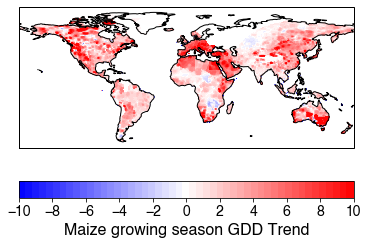

In [293]:
cRange=[-10, 10]
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(gddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 2))
cbar.set_label('%s growing season GDD Trend'%crop)
ax.coastlines()

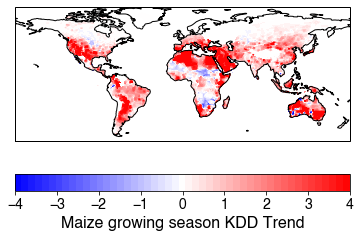

In [294]:
cRange=[-4, 4]
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(kddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 1))
cbar.set_label('%s growing season KDD Trend'%crop)
ax.coastlines()

In [295]:
# load crop yield trends from iizumi data

maize = np.zeros([360, 720, len(range(1981, 2011+1))])
maizeTrends = np.zeros([360, 720])

rice = np.zeros([360, 720, len(range(1981, 2011+1))])
riceTrends = np.zeros([360, 720])

soybean = np.zeros([360, 720, len(range(1981, 2011+1))])
soybeanTrends = np.zeros([360, 720])

wheat = np.zeros([360, 720, len(range(1981, 2011+1))])
wheatTrends = np.zeros([360, 720])

for year in range(1981, 2011+1):
    maizeNc = xr.open_dataset('%s/iizumi/maize/yield_%d.nc4'%(dataDirDiscovery, year), decode_cf=False)
    maizeNc.load()
    maizeNc = maizeNc.rename({'var':'maize_yield'})
    maize[:, :, year-1981] = np.flipud(maizeNc.maize_yield.values)
    
    soybeanNc = xr.open_dataset('%s/iizumi/soybean/yield_%d.nc4'%(dataDirDiscovery, year), decode_cf=False)
    soybeanNc.load()
    soybeanNc = soybeanNc.rename({'var':'soybean_yield'})
    soybean[:, :, year-1981] = np.flipud(soybeanNc.soybean_yield.values)
    
    riceNc = xr.open_dataset('%s/iizumi/rice/yield_%d.nc4'%(dataDirDiscovery, year), decode_cf=False)
    riceNc.load()
    riceNc = riceNc.rename({'var':'rice_yield'})
    rice[:, :, year-1981] = np.flipud(riceNc.rice_yield.values)
    
    wheatNc = xr.open_dataset('%s/iizumi/wheat/yield_%d.nc4'%(dataDirDiscovery, year), decode_cf=False)
    wheatNc.load()
    wheatNc = wheatNc.rename({'var':'wheat_yield'})
    wheat[:, :, year-1981] = np.flipud(wheatNc.wheat_yield.values)

maize[maize < 0] = np.nan
soybean[soybean < 0] = np.nan
rice[rice < 0] = np.nan
wheat[wheat < 0] = np.nan


In [296]:
maizeDetrend = np.full(maize.shape, np.nan)
kddDetrend = np.full(kdd.shape, np.nan)
gddDetrend = np.full(gdd.shape, np.nan)

for xlat in range(maize.shape[0]):
    for ylon in range(maize.shape[1]):
        nn = np.where((~np.isnan(maize[xlat, ylon, :])) & (~np.isnan(kdd[xlat, ylon, 0:maize.shape[2]])) & (~np.isnan(gdd[xlat, ylon, 0:maize.shape[2]])))[0]
        if len(nn) == maize.shape[2]:
            maizeDetrend[xlat, ylon, nn] = scipy.signal.detrend(maize[xlat, ylon, nn]) / np.linalg.norm(scipy.signal.detrend(maize[xlat, ylon, nn]))
            gddDetrend[xlat, ylon, nn] = scipy.signal.detrend(gdd[xlat, ylon, nn]) / np.linalg.norm(scipy.signal.detrend(gdd[xlat, ylon, nn]))
            kddDetrend[xlat, ylon, nn] = scipy.signal.detrend(kdd[xlat, ylon, nn]) / np.linalg.norm(scipy.signal.detrend(kdd[xlat, ylon, nn]))
        

In [297]:
# load NASS yield data

nassProd1 = pd.read_csv('%s/nass/nass-maize-production-1961-1974.csv'%dataDirDiscovery)
nassProd2 = pd.read_csv('%s/nass/nass-maize-production-1975-1994.csv'%dataDirDiscovery)
nassProd3 = pd.read_csv('%s/nass/nass-maize-production-1995-2019.csv'%dataDirDiscovery)
nassProd = pd.concat([nassProd1[::-1], nassProd2[::-1], nassProd3[::-1]])

nass1 = pd.read_csv('%s/nass/maize-yield-1961-1978.csv'%dataDirDiscovery)
nass2 = pd.read_csv('%s/nass/maize-yield-1979-1998.csv'%dataDirDiscovery)
nass3 = pd.read_csv('%s/nass/maize-yield-1999-2019.csv'%dataDirDiscovery)

nass = pd.concat([nass1[::-1], nass2[::-1], nass3[::-1]])


In [298]:
usStateAbbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [299]:
nassStates = list(nass['State'])
nassStateAbvs = []
for s in nassStates:
    nassStateAbvs.append(usStateAbbrev[s.lower().title()])
nass['StateAbvs'] = nassStateAbvs

nassProdStates = list(nassProd['State'])
nassProdStateAbvs = []
for s in nassProdStates:
    nassProdStateAbvs.append(usStateAbbrev[s.lower().title()])
nassProd['StateAbvs'] = nassProdStateAbvs

In [300]:
maizeYieldDeepak = []
for year in range(1981, 2013+1):
    curMaizeYield = xr.open_dataset('%s/deepak/Maize_yield_1970_2013/Maize_areaweightedyield_%d_ver12b.nc'%(dataDirDiscovery, year), decode_cf=False)
    
    if len(maizeYieldDeepak) == 0:
        maizeYieldDeepak = curMaizeYield
    else:
        maizeYieldDeepak = xr.concat([maizeYieldDeepak, curMaizeYield], dim='time')
    
maizeYieldDeepak.load()

# flip latitude axis so top is +90
latDeepak = np.flipud(maizeYieldDeepak.latitude)
lonDeepak = np.roll(maizeYieldDeepak.longitude, int(len(maizeYieldDeepak.longitude)/2), axis=0)
lonDeepak[lonDeepak<0] += 360
maizeYieldDeepak['Data'] = maizeYieldDeepak.Data.transpose('latitude', 'longitude', 'time', 'level')
maizeYieldDeepakData = np.roll(np.flip(maizeYieldDeepak.Data, axis=0), int(len(maizeYieldDeepak.longitude)/2), axis=1)

maizeYieldDeepak['latitude'] = latDeepak
maizeYieldDeepak['longitude'] = lonDeepak
maizeYieldDeepak['Data'] = (('latitude', 'longitude', 'time'), np.squeeze(maizeYieldDeepakData))

In [301]:
minCropYears = 30
minCropYearsDeepak = 30

if os.path.isfile('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData)):
    usCounties = pd.read_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))
else:
    usCounties = gpd.read_file('%s/us-county-lat-long/c_02jn20.shp'%dataDirDiscovery)

    usCounties['temp'] = np.full(len(usCounties), np.nan)
    usCounties['tempLatInds'] = np.full(len(usCounties), np.nan)
    usCounties['tempLonInds'] = np.full(len(usCounties), np.nan)
    usCounties['prLatInds'] = np.full(len(usCounties), np.nan)
    usCounties['prLonInds'] = np.full(len(usCounties), np.nan)
    usCounties['gdd'] = np.full(len(usCounties), np.nan)
    usCounties['kdd'] = np.full(len(usCounties), np.nan)
#     usCounties['gddWeekly'] = np.full(len(usCounties), np.nan)
#     usCounties['kddWeekly'] = np.full(len(usCounties), np.nan)
    usCounties['gddTrend'] = np.full(len(usCounties), np.nan)
    usCounties['kddTrend'] = np.full(len(usCounties), np.nan)
    usCounties['gddDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['kddDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['gddDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['kddDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecip'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYield'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldTrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldTrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendNormDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldYears'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProd'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdTrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdYears'] = np.full(len(usCounties), np.nan)

    # this is needed to store list in dataframe... kind of hacky
    usCounties = usCounties.astype(object)

    for c in range(usCounties.shape[0]):
        
        if c % 100 == 0:
            print('%.0f %% done'%(c/usCounties.shape[0]*100))
        
        bounds = usCounties['geometry'][c].bounds
        lat1 = bounds[1]
        lat2 = bounds[3]
        lon1 = bounds[0]
        lon2 = bounds[2]

        if lon1 < 0: lon1 += 360
        if lon2 < 0: lon2 += 360

        deepakLatInds = [np.where(abs(latDeepak-lat2) == np.nanmin(abs(latDeepak-lat2)))[0][0],
                   np.where(abs(latDeepak-lat1) == np.nanmin(abs(latDeepak-lat1)))[0][0]]
        deepakLonInds = [np.where(abs(lonDeepak-lon1) == np.nanmin(abs(lonDeepak-lon1)))[0][0],
                   np.where(abs(lonDeepak-lon2) == np.nanmin(abs(lonDeepak-lon2)))[0][0]]
            
        tempLatInds = [np.where(abs(lat-lat2) == np.nanmin(abs(lat-lat2)))[0][0],
                   np.where(abs(lat-lat1) == np.nanmin(abs(lat-lat1)))[0][0]]
        tempLonInds = [np.where(abs(lon-lon1) == np.nanmin(abs(lon-lon1)))[0][0],
                   np.where(abs(lon-lon2) == np.nanmin(abs(lon-lon2)))[0][0]]
        
        prLatInds = [np.where(abs(sacksLat-lat2) == np.nanmin(abs(sacksLat-lat2)))[0][0],
                   np.where(abs(sacksLat-lat1) == np.nanmin(abs(sacksLat-lat1)))[0][0]]
        prLonInds = [np.where(abs(sacksLon-lon1) == np.nanmin(abs(sacksLon-lon1)))[0][0],
                   np.where(abs(sacksLon-lon2) == np.nanmin(abs(sacksLon-lon2)))[0][0]]
        
        if len(tempLatInds) == 0 or len(tempLonInds) == 0 or \
           len(prLatInds) == 0 or len(prLonInds) == 0:
            break

        usCounties['tempLatInds'][c] = tempLatInds
        usCounties['tempLonInds'][c] = tempLonInds
        
        usCounties['prLatInds'][c] = prLatInds
        usCounties['prLonInds'][c] = prLonInds
        
        if len(deepakLatInds) > 1:
            countyYieldDeepak = np.nanmean(maizeYieldDeepak.Data.values[deepakLatInds, :, :], axis=0)
        else:
            countyYieldDeepak = np.squeeze(maizeYieldDeepak.Data.values[deepakLatInds, :, :])
        
        if len(deepakLonInds) > 1:
            countyYieldDeepak = np.nanmean(countyYieldDeepak[deepakLonInds, :], axis=0)
        else:
            countyYieldDeepak = np.squeeze(countyYieldDeepak[deepakLonInds, :])
        
        # add padding so yield array is same length as nass arrays
        countyYieldDeepak = np.pad(countyYieldDeepak, (0, 5), 'constant', constant_values=(np.nan))
        
        tempLatIndsRange = np.arange(min(tempLatInds), max(tempLatInds)+1)
        tempLonIndsRange = np.arange(min(tempLonInds), max(tempLonInds)+1)
        
        prLatIndsRange = np.arange(min(prLatInds), max(prLatInds)+1)
        prLonIndsRange = np.arange(min(prLonInds), max(prLonInds)+1)

        if len(tempLatIndsRange) > 1:
            countyGdd = np.nanmean(gdd[tempLatIndsRange, :, :], axis=0)
            countyKdd = np.nanmean(kdd[tempLatIndsRange, :, :], axis=0)
            
#             countyGddWeekly = np.nanmean(gddWeekly[tempLatIndsRange, :, :, :], axis=0)
#             countyKddWeekly = np.nanmean(kddWeekly[tempLatIndsRange, :, :, :], axis=0)
        else:
            countyGdd = np.squeeze(gdd[tempLatIndsRange, :, :])
            countyKdd = np.squeeze(kdd[tempLatIndsRange, :, :])
            
#             countyGddWeekly = np.squeeze(gddWeekly[tempLatIndsRange, :, :, :])
#             countyKddWeekly = np.squeeze(kddWeekly[tempLatIndsRange, :, :, :])
        
        if len(prLatIndsRange) > 1:
            countyPrecip = np.nanmean(seasonalPrecip[prLatIndsRange, :, :], axis=0)
        else:
            countyPrecip = np.squeeze(seasonalPrecip[prLatIndsRange, :, :])

        if len(tempLonIndsRange) > 1:
            countyGdd = np.nanmean(countyGdd[tempLonIndsRange, :], axis=0)
            countyKdd = np.nanmean(countyKdd[tempLonIndsRange, :], axis=0)
            
#             countyGddWeekly = np.nanmean(countyGddWeekly[tempLonIndsRange, :, :], axis=0)
#             countyKddWeekly = np.nanmean(countyKddWeekly[tempLonIndsRange, :, :], axis=0)
        else:
            countyGdd = np.squeeze(countyGdd[tempLonIndsRange, :])
            countyKdd = np.squeeze(countyKdd[tempLonIndsRange, :])
            
#             countyGddWeekly = np.squeeze(countyGddWeekly[tempLonIndsRange, :, :])
#             countyKddWeekly = np.squeeze(countyKddWeekly[tempLonIndsRange, :, :])
        
        if len(prLonIndsRange) > 1:
            countyPrecip = np.nanmean(countyPrecip[prLonIndsRange, :], axis=0)
        else:
            countyPrecip = np.squeeze(countyPrecip[prLonIndsRange, :])

        curCountyName = usCounties['COUNTYNAME'][c].lower()
        nassYieldCounties = np.array(list(map(str.lower, nass['County'])))
        nassProdCounties = np.array(list(map(str.lower, nassProd['County'])))

        curStateName = usCounties['STATE'][c].lower()
        nassYieldStates = np.array(list(map(str.lower, nass['StateAbvs'])))
        nassProdStates = np.array(list(map(str.lower, nassProd['StateAbvs'])))

        countyIndYield = np.where((curCountyName == nassYieldCounties) & (curStateName == nassYieldStates))[0]
        countyIndProd = np.where((curCountyName == nassProdCounties) & (curStateName == nassProdStates))[0]

        curCountyYieldYears = np.array(list(nass['Year']))
        curCountyYieldYears = curCountyYieldYears[countyIndYield]

        curCountyYield = np.array(list(nass['Value']))
        curCountyYield = curCountyYield[countyIndYield]
        
        curCountyProdYears = np.array(list(nassProd['Year']))
        curCountyProdYears = curCountyProdYears[countyIndProd]
        
        curCountyProd = np.array(list(nassProd['Value']))
        curCountyProd = curCountyProd[countyIndProd]

        yieldYearsUniform = np.arange(1981, 2018+1)
        yieldUniform = np.full(yieldYearsUniform.shape, np.nan)
        yieldUniformDetrend = np.full(yieldYearsUniform.shape, np.nan)
        yieldUniformDetrendNorm = np.full(yieldYearsUniform.shape, np.nan)
        
        for y, year in enumerate(curCountyYieldYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(yieldYearsUniform):
                yieldUniform[indUniform] = curCountyYield[y]
        
        prodYearsUniform = np.arange(1981, 2018+1)
        prodUniform = np.full(prodYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountyProdYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(prodYearsUniform):
                prodUniform[indUniform] = float(curCountyProd[y].replace(',', ''))
        
        # find longest consequtative sequence of years with yield data
        ptMax = (-1, -1)
        ptCur = (-1, -1)
        for i, val in enumerate(yieldUniform):
            # start sequence
            if ~np.isnan(val) and ptCur[0] == -1:
                ptCur = (i, -1)
            #end sequence
            elif (np.isnan(val) and ptCur[0] >= 0):
                ptCur = (ptCur[0], i)
                if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                    ptMax = ptCur
                ptCur = (-1, -1)
            # reached end of sequence
            elif i >= len(yieldUniform)-1 and ptCur[0] >= 0:
                ptCur = (ptCur[0], i)
                if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                    ptMax = ptCur
        
        if ptMax[1]-ptMax[0]+1 >= minCropYears:
            
            inds = np.arange(ptMax[0], ptMax[1])
            
            yieldUniformDetrendNorm[inds] = scipy.signal.detrend(yieldUniform[inds]) / np.linalg.norm(scipy.signal.detrend(yieldUniform[inds]))
            yieldUniformDetrend[inds] = scipy.signal.detrend(yieldUniform[inds])
            yieldUniform[:ptMax[0]] = np.nan
            yieldUniform[ptMax[1]:] = np.nan
            
            X = sm.add_constant(range(len(yieldUniform[inds])))
            mdl = sm.OLS(yieldUniform[inds], X).fit()
            usCounties['maizeYieldTrend'][c] = mdl.params[1]
            
            prodUniform[:ptMax[0]] = np.nan
            prodUniform[ptMax[1]:] = np.nan
            
            if len(np.where(np.isnan(prodUniform[ptMax[0]:ptMax[1]+1]))[0]) == 0:
                X = sm.add_constant(range(len(prodUniform[ptMax[0]:ptMax[1]+1])))
                mdl = sm.OLS(prodUniform[ptMax[0]:ptMax[1]+1], X).fit()
                usCounties['maizeProdTrend'][c] = mdl.params[1]
            else:
                usCounties['maizeProdTrend'][c] = np.nan
            
            
            # do the same but with deepak data
            
            yieldUniformDetrendDeepak = np.full(yieldYearsUniform.shape, np.nan)
            yieldUniformDetrendNormDeepak = np.full(yieldYearsUniform.shape, np.nan)
            
            ptMaxDeepak = (-1, -1)
            ptCurDeepak = (-1, -1)
            for i, val in enumerate(countyYieldDeepak):
                # start sequence
                if ~np.isnan(val) and ptCurDeepak[0] == -1:
                    ptCurDeepak = (i, -1)
                #end sequence
                elif (np.isnan(val) and ptCurDeepak[0] >= 0):
                    ptCurDeepak = (ptCurDeepak[0], i)
                    if ptCurDeepak[1]-ptCurDeepak[0] > ptMaxDeepak[1]-ptMaxDeepak[0] or ptMaxDeepak == (-1, -1):
                        ptMaxDeepak = ptCurDeepak
                    ptCurDeepak = (-1, -1)
                # reached end of sequence
                elif i >= len(countyYieldDeepak)-1 and ptCurDeepak[0] >= 0:
                    ptCurDeepak = (ptCurDeepak[0], i)
                    if ptCurDeepak[1]-ptCurDeepak[0] > ptMaxDeepak[1]-ptMaxDeepak[0] or ptMaxDeepak == (-1, -1):
                        ptMaxDeepak = ptCurDeepak
                        
            if ptMaxDeepak[1]-ptMaxDeepak[0]+1 >= minCropYearsDeepak:
            
                inds = np.arange(ptMaxDeepak[0], ptMaxDeepak[1])

                yieldUniformDetrendNormDeepak[inds] = scipy.signal.detrend(countyYieldDeepak[inds]) / np.linalg.norm(scipy.signal.detrend(countyYieldDeepak[inds]))
                yieldUniformDetrendDeepak[inds] = scipy.signal.detrend(countyYieldDeepak[inds])
                countyYieldDeepak[:ptMaxDeepak[0]] = np.nan
                countyYieldDeepak[ptMaxDeepak[1]:] = np.nan

                X = sm.add_constant(range(len(countyYieldDeepak[inds])))
                mdl = sm.OLS(countyYieldDeepak[inds], X).fit()
                usCounties['maizeYieldTrendDeepak'][c] = mdl.params[1]
            
            countyGdd[countyGdd < 0] = np.nan
            usCounties['gdd'][c] = np.full(countyGdd.shape, np.nan)
            usCounties['gdd'][c][inds] = countyGdd[inds]
            usCounties['gddDetrend'][c] = np.full(countyGdd.shape, np.nan)
            usCounties['gddDetrend'][c][inds] = scipy.signal.detrend(countyGdd[inds]) 
            usCounties['gddDetrendNorm'][c] = np.full(countyGdd.shape, np.nan)
            usCounties['gddDetrendNorm'][c][inds] = scipy.signal.detrend(countyGdd[inds]) / np.linalg.norm(scipy.signal.detrend(countyGdd[inds]))
            
            X = sm.add_constant(range(len(countyGdd[inds])))
            mdl = sm.OLS(countyGdd[inds], X).fit()
            usCounties['gddTrend'][c] = mdl.params[1]
            
            countyKdd[countyKdd < 0] = np.nan
            usCounties['kdd'][c] = np.full(countyKdd.shape, np.nan)
            usCounties['kdd'][c][inds] = countyKdd[inds]
            usCounties['kddDetrend'][c] = np.full(countyKdd.shape, np.nan)
            usCounties['kddDetrend'][c][inds] = scipy.signal.detrend(countyKdd[inds]) 
            usCounties['kddDetrendNorm'][c] = np.full(countyKdd.shape, np.nan)
            usCounties['kddDetrendNorm'][c][inds] = scipy.signal.detrend(countyKdd[inds]) / np.linalg.norm(scipy.signal.detrend(countyKdd[inds]))
            
            X = sm.add_constant(range(len(countyKdd[inds])))
            mdl = sm.OLS(countyKdd[inds], X).fit()
            usCounties['kddTrend'][c] = mdl.params[1]
            
            countyPrecip[countyPrecip < 0] = np.nan
            usCounties['seasonalPrecip'][c] = np.full(countyPrecip.shape, np.nan)
            usCounties['seasonalPrecip'][c][inds] = countyPrecip[inds]
            usCounties['seasonalPrecipDetrend'][c] = np.full(countyPrecip.shape, np.nan)
            usCounties['seasonalPrecipDetrend'][c][inds] = scipy.signal.detrend(countyPrecip[inds]) 
            usCounties['seasonalPrecipDetrendNorm'][c] = np.full(countyPrecip.shape, np.nan)
            usCounties['seasonalPrecipDetrendNorm'][c][inds] = scipy.signal.detrend(countyPrecip[inds]) / np.linalg.norm(scipy.signal.detrend(countyPrecip[inds]))
            
            
            X = sm.add_constant(range(len(countyPrecip[inds])))
            mdl = sm.OLS(countyPrecip[inds], X).fit()
            usCounties['seasonalPrecipTrend'][c] = mdl.params[1]
            
        else:
            usCounties['maizeYieldTrend'][c] = np.nan
            usCounties['maizeProdTrend'][c] = np.nan
            
            usCounties['gddDetrend'][c] = np.full(countyGdd.shape, np.nan)
            usCounties['gddDetrendNorm'][c] = np.full(countyGdd.shape, np.nan)
            usCounties['gddTrend'][c] = np.full(countyGdd.shape, np.nan)
            
            usCounties['kddDetrend'][c] = np.full(countyKdd.shape, np.nan)
            usCounties['kddDetrendNorm'][c] = np.full(countyKdd.shape, np.nan)
            usCounties['kddTrend'][c] = np.full(countyKdd.shape, np.nan)
            
            usCounties['seasonalPrecipDetrend'][c] = np.full(countyPrecip.shape, np.nan)
            usCounties['seasonalPrecipDetrendNorm'][c] = np.full(countyPrecip.shape, np.nan)
            usCounties['seasonalPrecipTrend'][c] = np.full(countyPrecip.shape, np.nan)
        
        usCounties['maizeYieldYears'][c] = yieldYearsUniform
        usCounties['maizeYield'][c] = yieldUniform
        usCounties['maizeYieldDeepak'][c] = countyYieldDeepak
        usCounties['maizeYieldDetrend'][c] = yieldUniformDetrend
        usCounties['maizeYieldDetrendDeepak'][c] = yieldUniformDetrendDeepak
        usCounties['maizeYieldDetrendNorm'][c] = yieldUniformDetrendNorm
        usCounties['maizeYieldDetrendNormDeepak'][c] = yieldUniformDetrendNormDeepak
        usCounties['maizeProdYears'][c] = prodYearsUniform
        usCounties['maizeProd'][c] = prodUniform
        
    usCounties.to_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))

In [302]:
usCounties = usCounties.drop(columns=['CWA', 'TIME_ZONE', 'FE_AREA'])

In [303]:
# drop all counties with any nans
yieldNans = np.array(list(map(np.isnan, usCounties['maizeYield'])))
yieldTrendNans = np.array(list(map(np.isnan, usCounties['maizeYieldTrend'])))
gddNans = np.array(list(map(np.isnan, usCounties['gdd'])))
kddNans = np.array(list(map(np.isnan, usCounties['kdd'])))
# inds1 = np.where( (np.array([len(np.where((yieldNans[i]==False) & ((gddNans[i]==True) | (kddNans[i]==True)))[0]) for i in range(len(yieldNans))]) > 0))[0]
inds = np.where((yieldTrendNans == True))[0]
# inds = np.union1d(inds1, inds2)

In [304]:
usCounties = usCounties.drop(index=inds)

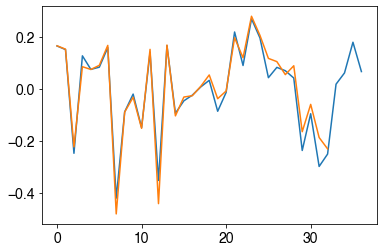

In [305]:
i = 3143

y=np.array(usCounties['maizeYieldDetrendNorm'][i])
yd=np.array(usCounties['maizeYieldDetrendNormDeepak'][i])

plt.figure()
plt.plot(y)
plt.plot(yd)

In [306]:
yt = []
kt = []
pr = []
prod = []

for state in usStateAbbrev.values():
    n =  list(usCounties['STATE']).count(state)
    if n >= 10: 
        p = np.array([np.array(x) for x in np.array(usCounties[usCounties['STATE']==state]['maizeProd'])])
        prod.append(p)
        yt.append(usCounties[usCounties['STATE']==state]['maizeYieldTrend'].mean().mean())
        kt.append(usCounties[usCounties['STATE']==state]['kddTrend'].mean().mean())
        pr.append(usCounties[usCounties['STATE']==state]['seasonalPrecipTrend'].mean().mean())
        usCounties[usCounties['STATE']==state]['maizeProd']
        print('%s : %d : yield trend = %.1f : kdd trend = %.1f'%(state, n, \
                                                                             usCounties[usCounties['STATE']==state]['maizeYieldTrend'].mean().mean(), \
                                                                             usCounties[usCounties['STATE']==state]['kddTrend'].mean().mean()))
prod = np.array(prod)

GA : 24 : yield trend = 2.6 : kdd trend = 1.3
IL : 97 : yield trend = 2.0 : kdd trend = 0.4
IN : 86 : yield trend = 1.7 : kdd trend = 0.6
IA : 98 : yield trend = 2.3 : kdd trend = -0.2
KS : 37 : yield trend = 0.7 : kdd trend = 3.2
KY : 72 : yield trend = 1.7 : kdd trend = 0.6
LA : 11 : yield trend = 2.6 : kdd trend = 2.4
MD : 22 : yield trend = 1.7 : kdd trend = 1.6
MI : 41 : yield trend = 1.9 : kdd trend = 0.3
MN : 66 : yield trend = 2.4 : kdd trend = -0.4
MS : 14 : yield trend = 2.6 : kdd trend = 1.7
MO : 75 : yield trend = 1.5 : kdd trend = 1.0
NE : 82 : yield trend = 1.9 : kdd trend = 1.1
NJ : 10 : yield trend = 0.9 : kdd trend = 1.4
NY : 16 : yield trend = 1.5 : kdd trend = 0.2
NC : 70 : yield trend = 1.3 : kdd trend = 1.0
ND : 15 : yield trend = 2.2 : kdd trend = -1.2
OH : 69 : yield trend = 1.7 : kdd trend = 0.7
PA : 32 : yield trend = 1.5 : kdd trend = 0.6
SC : 22 : yield trend = 1.2 : kdd trend = 0.3
SD : 48 : yield trend = 2.4 : kdd trend = -0.6
TN : 38 : yield trend = 1.9 : 

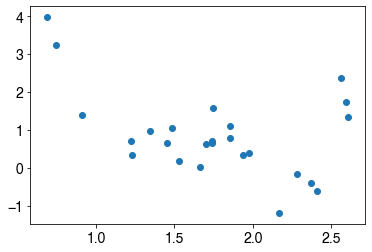

In [307]:
plt.scatter(yt,kt)

yield trend vs. kdd trend: coef = -0.22, p = 0.00
starting yields vs. kdd trends: coef = -0.60, p = 0.03


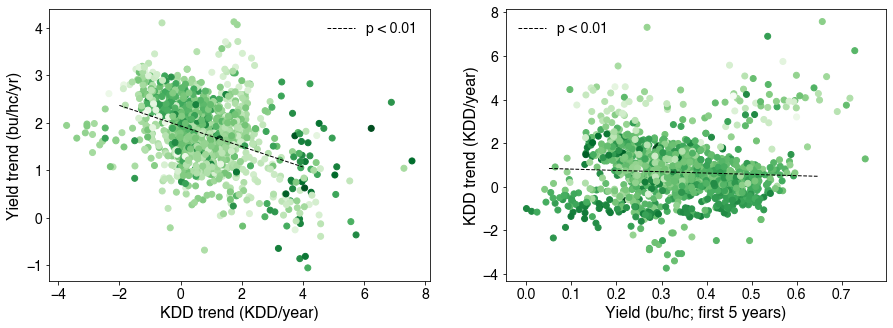

In [308]:
# countyList = usCounties[(usCounties['STATE']=='IA')]
countyList = usCounties

gddAnoms = np.array(list(countyList['gddDetrend']))
kddAnoms = np.array(list(countyList['kddDetrend']))
yieldAnoms = np.array(list(countyList['maizeYieldDetrend']))

gddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
yieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['maizeYieldDetrend']))])))

kddTrendAgg = np.array([x for x in countyList['kddTrend']])
kddTrendAggNorm = (kddTrendAgg-np.nanmin(kddTrendAgg))/np.nanmax(kddTrendAgg)
yieldTrendAgg = np.array([x for x in countyList['maizeYieldTrend']])
yieldTrendAggNorm = (yieldTrendAgg-np.nanmin(yieldTrendAgg))/np.nanmax(yieldTrendAgg)

gddValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gdd']))])))
kddValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kdd']))])))
yieldValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['maizeYield']))])))

startingYields = []
for startingYield in np.array(list(countyList['maizeYield'])):
    ind1 = np.where(~np.isnan(startingYield))[0][0]
    ind2 = ind1+5
    if ind2 > len(startingYield): ind2 = len(startingYield)
    startingYields.append(np.nanmean(startingYield[ind1:ind2]))

startingYieldsNorm = (startingYields-np.nanmin(startingYields)) / np.nanmax(startingYields)

f, (ax1, ax3) = plt.subplots(figsize=(15, 5), nrows=1, ncols=2, squeeze=True)

X = sm.add_constant(kddTrendAgg)
mdl1 = sm.RLM(yieldTrendAgg, X).fit()

ax1.scatter(kddTrendAgg, yieldTrendAgg, c=startingYieldsNorm, cmap='Greens')
ax1.plot([-2, 4], mdl1.params[0]+[-2*mdl1.params[1], 4*mdl1.params[1]], '--k', lw=1, label = 'p < 0.01')
ax1.set_xlabel('KDD trend (KDD/year)')
ax1.set_ylabel('Yield trend (bu/hc/yr)')
l1 = ax1.legend(prop = {'size':14, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)


# ax2.scatter(kddValsAgg, yieldValsAgg)
# ax2.set_xlabel('KDD anomaly')
# ax2.set_ylabel('Yield anomaly')

# X = sm.add_constant(startingYieldsNorm)
# mdl2 = sm.RLM(yieldTrendAgg, X).fit()

# ax2.scatter(startingYieldsNorm, yieldTrendAgg, c=kddTrendAggNorm, cmap='Reds')
# ax2.plot([0.05, 0.65], mdl2.params[0]+[0.05*mdl2.params[1], 0.65*mdl2.params[1]], '--k', lw=1, label = 'p = 0.01')
# ax2.set_xlabel('Yield (1981-1985)')
# ax2.set_ylabel('Yield trend')
# l2 = ax2.legend(prop = {'size':14, 'family':'Helvetica'})
# l2.get_frame().set_linewidth(0)


X = sm.add_constant(startingYieldsNorm)
mdl3 = sm.RLM(kddTrendAgg, X).fit()

ax3.scatter(startingYieldsNorm, kddTrendAgg, c=yieldTrendAggNorm, cmap='Greens')
ax3.plot([0.05, 0.65], mdl3.params[0]+[0.05*mdl3.params[1], 0.65*mdl3.params[1]], '--k', lw=1, label = 'p < 0.01')
ax3.set_xlabel('Yield (bu/hc; first 5 years)')
ax3.set_ylabel('KDD trend (KDD/year)')
l3 = ax3.legend(prop = {'size':14, 'family':'Helvetica'})
l3.get_frame().set_linewidth(0)


print('yield trend vs. kdd trend: coef = %.2f, p = %.2f'%(mdl1.params[1], mdl1.pvalues[1]))
# print('starting yields vs. yield trends: coef = %.4f, p = %.2f'%(mdl2.params[1], mdl2.pvalues[1]))
print('starting yields vs. kdd trends: coef = %.2f, p = %.2f'%(mdl3.params[1], mdl3.pvalues[1]))


In [309]:
gddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
prAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['seasonalPrecipDetrend']))])))
yieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['maizeYieldDetrend']))])))
countyFE = np.array(list(itertools.chain.from_iterable([[c]*(yearRange[1]-yearRange[0]+1) for c in range(len(list(countyList['maizeYieldDetrend'])))])))
    

data = {'GDD':gddAnomAgg, \
        'KDD':kddAnomAgg, \
        'Pr':prAnomAgg, 'Pr2':prAnomAgg**2, \
        'County':countyFE, \
        'Yield':yieldAnomAgg}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                           'County', \
                           'Yield'])
mdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     6757.
Date:                Fri, 10 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:22:34   Log-Likelihood:            -1.7302e+05
No. Observations:               40609   AIC:                         3.460e+05
Df Residuals:                   40605   BIC:                         3.461e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8904      0.085    -10.466      0.000      -1.057      -0.724
GDD            0.0455      0.001     31.587      0.000       0.043       0.048
KDD           -0.2295      0.002    -97.995      0.000      -0.234      -0.225
Pr            -0.2193      0.033     -6.738      0.000      -0.283      -0.156
==============================================================================
Omnibus:                     3579.391   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6336.785
Skew:                          -0.629   Prob(JB):                         0.00
Kurtosis:                       4.470   Cond. No.                         114.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [310]:
gddAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
prAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['seasonalPrecipDetrend']))])))
yieldAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['maizeYieldDetrendDeepak']))])))
countyFE = np.array(list(itertools.chain.from_iterable([[c]*(yearRange[1]-yearRange[0]+1) for c in range(len(list(countyList['maizeYieldDetrend'])))])))

nn = np.where((~np.isnan(gddAnomAggDeepak)) & (~np.isnan(kddAnomAggDeepak)) & (~np.isnan(prAnomAggDeepak)) & (~np.isnan(yieldAnomAggDeepak)))[0]

data = {'GDD':gddAnomAggDeepak[nn], \
        'KDD':kddAnomAggDeepak[nn], \
        'Pr':prAnomAggDeepak[nn], 'Pr2':prAnomAggDeepak[nn]**2, \
        'County':countyFE[nn], \
        'Yield':yieldAnomAggDeepak[nn]}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                           'County', \
                           'Yield'])
mdlDeepak = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
mdlDeepak.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     9409.
Date:                Fri, 10 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:22:34   Log-Likelihood:                -54366.
No. Observations:               41114   AIC:                         1.087e+05
Df Residuals:                   41110   BIC:                         1.088e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.283e-16      0.004   2.07e-13      1.000      -0.009       0.009
GDD            0.0027   7.58e-05     35.364      0.000       0.003       0.003
KDD           -0.0140      0.000   -114.322      0.000      -0.014      -0.014
Pr            -0.0124      0.002     -7.238      0.000      -0.016      -0.009
==============================================================================
Omnibus:                     4172.498   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7859.539
Skew:                          -0.684   Prob(JB):                         0.00
Kurtosis:                       4.648   Cond. No.                         114.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [311]:
stateMdls = {}

# build state models
for state in usStateAbbrev.values():
    
    gddAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['gddDetrend']))])))
    kddAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['kddDetrend']))])))
    prAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['seasonalPrecipDetrend']))])))
    yieldAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['maizeYieldDetrend']))])))
    
    nn = np.where((~np.isnan(gddAgg)) & (~np.isnan(kddAgg)) & (~np.isnan(prAgg)) & (~np.isnan(yieldAgg)))[0]
    
    if len(nn) > 1000:
#         print('building model for %s, n = %d'%(state, len(nn)))
    
        data = {'GDD':gddAgg[nn], \
            'KDD':kddAgg[nn], \
            'Pr':prAgg[nn], 'Pr2':prAgg[nn]**2, \
            'Yield':yieldAgg[nn]}

        df = pd.DataFrame(data, \
                          columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                                   'Yield'])
        stateMdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
        stateMdls[state] = stateMdl

In [ ]:
startPeriod = range(3, 12)
endPeriod = range(3, 12)

countyFips = np.array(list(countyList['FIPS']))
states = np.array(list(countyList['STATE']))
startingYields = np.array(list(countyList['maizeYield']))

countyOutcomes = {}
countyOutcomesDeepak = {}
countyGddChg = {}
countyKddChg = {}
countyPrChg = {}

for c, fips in enumerate(countyFips):
    if c % 50 == 0:
        print('%.0f %%'%(c/len(countyFips)*100))
    
    if states[c] not in stateMdls.keys():
        continue
    
    curCountyOutcomes = []
    curCountyOutcomesDeepak = []
    curCountyGddChg = []
    curCountyKddChg = []
    curCountyPrChg = []
    
    
#     countyGdd = np.array(list(usCounties['gddDetrend']))[c, :]
#     countyKdd = np.array(list(usCounties['kddDetrend']))[c, :]
#     countyPr = np.array(list(usCounties['seasonalPrecipDetrend']))[c, :]
#     countyYield = np.array(list(usCounties['maizeYieldDetrend']))[c, :]
    
#     nn = np.where((~np.isnan(countyGdd)) & (~np.isnan(countyKdd)) & (~np.isnan(countyPr)) & (~np.isnan(countyYield)))[0]
    
#     # build county-specific model
#     data = {'GDD':countyGdd[nn], \
#             'KDD':countyKdd[nn], \
#             'Pr':countyPr[nn], 'Pr2':countyPr[nn]**2, \
#             'Yield':countyYield[nn]}
                        
#     df = pd.DataFrame(data, \
#                       columns=['GDD', 'KDD', 'Pr', 'Pr2', \
#                                'Yield'])
#     countyMdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
    
#     gddMean = np.nanmean(np.array(list(usCounties['gdd']))[c, :])
#     kddMean = np.nanmean(np.array(list(usCounties['kdd']))[c, :])
#     prMean = np.nanmean(np.array(list(usCounties['seasonalPrecip']))[c, :])
    
    countyYieldInd1 = np.where(~np.isnan(startingYields[c, :]))[0][0]
    countyYieldInd2 = np.where(~np.isnan(startingYields[c, :]))[0][-1]
    
    curCountyGdd = np.array(list(usCounties['gdd']))[c, countyYieldInd1:(countyYieldInd2+1)]
#     curCountyGdd /= np.linalg.norm(curCountyGdd)
    curCountyKdd = np.array(list(usCounties['kdd']))[c, countyYieldInd1:(countyYieldInd2+1)]
#     curCountyKdd /= np.linalg.norm(curCountyKdd)
    curCountyPr = np.array(list(usCounties['seasonalPrecip']))[c, countyYieldInd1:(countyYieldInd2+1)]
#     curCountyPr /= np.linalg.norm(curCountyPr)
    
    for sp in startPeriod:
        for ep in endPeriod:
            
            curCountyStartingYields = np.nanmean(startingYields[c, countyYieldInd1:countyYieldInd1+sp])
            curCountyGddStart = curCountyGdd[:sp+1]
            curCountyKddStart = curCountyKdd[:sp+1]
            curCountyPrStart = curCountyPr[:sp+1]

            curCountyGddEnd = curCountyGdd[ep:]
            curCountyKddEnd = curCountyKdd[ep:]
            curCountyPrEnd = curCountyPr[ep:]

            XStart = {'GDD':curCountyGddStart, 'KDD':curCountyKddStart, 'Pr':curCountyPrStart, 'Pr2':curCountyPrStart**2, 'County':[c]*len(curCountyGddStart)}
            XEnd = {'GDD':curCountyGddEnd, 'KDD':curCountyKddEnd, 'Pr':curCountyPrEnd, 'Pr2':curCountyPrEnd**2, 'County':[c]*len(curCountyGddEnd)}
            
            predDeepak1 = mdlDeepak.predict(XStart).mean()
            predDeepak2 = mdlDeepak.predict(XEnd).mean()
            pred1 = mdl.predict(XStart).mean()
            pred2 = mdl.predict(XEnd).mean()
#             pred1 = stateMdls[states[c]].predict(XStart).mean()
#             pred2 = stateMdls[states[c]].predict(XEnd).mean()
            predChg = (pred2-pred1)/pred1*100
            predChgDeepak = (predDeepak2-predDeepak1)/predDeepak1*100
            
            if predChg < -50 or predChg > 50: predChg = np.nan
            if predChgDeepak < -50 or predChgDeepak > 50: predChgDeepak = np.nan
                
            curCountyOutcomes.append(predChg)
            curCountyOutcomesDeepak.append(predChgDeepak)
            curCountyGddChg.append(np.nanmean(curCountyGddEnd) - np.nanmean(curCountyGddStart))
            curCountyKddChg.append(np.nanmean(curCountyKddEnd) - np.nanmean(curCountyKddStart))
            curCountyPrChg.append(np.nanmean(curCountyPrEnd) - np.nanmean(curCountyPrStart))
    
    countyOutcomes[c] = np.nanmean(curCountyOutcomes)
    countyOutcomesDeepak[c] = np.nanmean(curCountyOutcomesDeepak)
    countyGddChg[c] = np.nanmean(curCountyGddChg)
    countyKddChg[c] = np.nanmean(curCountyKddChg)
    countyPrChg[c] = np.nanmean(curCountyPrChg)

0 %
4 %
8 %
12 %
16 %


In [ ]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-100, vmax=100)
cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyKddChg.keys():
        curKddChg = countyKddChg[ind[0]]
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curKddChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
plt.show()

In [ ]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-100, vmax=100)
cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyGddChg.keys():
        curGddChg = countyGddChg[ind[0]]
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curGddChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
plt.show()

In [ ]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-3, vmax=3)
cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyPrChg.keys():
        curPrChg = countyPrChg[ind[0]]
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curPrChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
plt.show()

In [ ]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-50, vmax=50)
cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomes.keys():
        curYieldChg = countyOutcomes[ind[0]]
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
plt.show()

In [ ]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-50, vmax=50)
cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomesDeepak.keys():
        curYieldChg = countyOutcomesDeepak[ind[0]]
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
plt.show()

In [283]:
print(stateMdls['IA'].summary())
print(stateMdls['MO'].summary())

                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     682.2
Date:                Fri, 10 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:19:08   Log-Likelihood:                -13758.
No. Observations:                3234   AIC:                         2.752e+04
Df Residuals:                    3230   BIC:                         2.755e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1516      0.300     -3.842      0.0

(array([ 36.,  55.,  51.,  92., 246., 369., 117.,  27.,  20.,   3.]),
 array([-48.12538863, -38.35959898, -28.59380933, -18.82801968,
         -9.06223003,   0.70355962,  10.46934927,  20.23513892,
         30.00092857,  39.76671822,  49.53250787]),
 <a list of 10 Patch objects>)

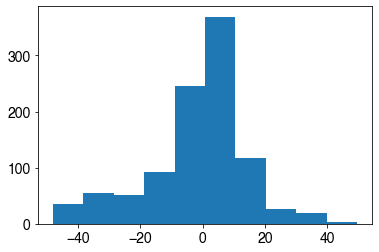

In [117]:
plt.hist([x for x in countyOutcomes.values()])

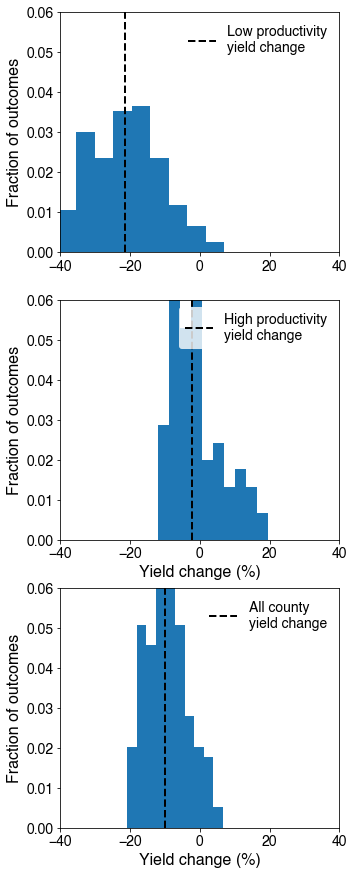

In [118]:
startPeriod = range(3, 15)
endPeriod = range(3, 15)

lowYieldThresh = 25
highYieldThresh = 75

pl = []
ph = []
pa = []

for sp in startPeriod:
    
    startingYields = []
    countyInds = []
    for startingYield in np.array(list(countyList['maizeYield'])):
        indStart = np.where(~np.isnan(startingYield))[0][0]
        indEnd = np.where(~np.isnan(startingYield))[0][-1]
        
        countyInds.append((indStart, indEnd))
        
        ind2 = indStart+sp
        if ind2 > len(startingYield): 
            ind2 = len(startingYield)
        startingYields.append(np.nanmean(startingYield[indStart:ind2]))
    
    for ep in endPeriod:
        indLow = np.where((startingYields < np.nanpercentile(startingYields, lowYieldThresh)))[0]
        indHigh = np.where((startingYields >= np.nanpercentile(startingYields, highYieldThresh)))[0]

        gddAggLowStart = np.array(list(itertools.chain.from_iterable([x[countyInds[i][0]:countyInds[i][0]+sp] for i, x in enumerate(np.array(list(usCounties['gdd']))[indLow])])))
        kddAggLowStart = np.array(list(itertools.chain.from_iterable([x[countyInds[i][0]:countyInds[i][0]+sp] for i, x in enumerate(np.array(list(usCounties['kdd']))[indLow])])))
        prAggLowStart = np.array(list(itertools.chain.from_iterable([x[countyInds[i][0]:countyInds[i][0]+sp] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indLow])])))
        countyFELowStart = np.array(list(itertools.chain.from_iterable([[c]*(sp) for c in indLow])))
        
        gddAggLowEnd = np.array(list(itertools.chain.from_iterable([x[countyInds[i][1]-(ep-1):countyInds[i][1]+1] for i, x in enumerate(np.array(list(usCounties['gdd']))[indLow])])))
        kddAggLowEnd = np.array(list(itertools.chain.from_iterable([x[countyInds[i][1]-(ep-1):countyInds[i][1]+1] for i, x in enumerate(np.array(list(usCounties['kdd']))[indLow])])))
        prAggLowEnd = np.array(list(itertools.chain.from_iterable([x[countyInds[i][1]-(ep-1):countyInds[i][1]+1] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indLow])])))
        countyFELowEnd = np.array(list(itertools.chain.from_iterable([[c]*(ep) for c in indLow])))
        
        gddAggAllStart = np.array(list(itertools.chain.from_iterable([x[countyInds[i][0]:countyInds[i][0]+sp] for i, x in enumerate(np.array(list(usCounties['gdd'])))])))
        kddAggAllStart = np.array(list(itertools.chain.from_iterable([x[countyInds[i][0]:countyInds[i][0]+sp] for i, x in enumerate(np.array(list(usCounties['kdd'])))])))
        prAggAllStart = np.array(list(itertools.chain.from_iterable([x[countyInds[i][0]:countyInds[i][0]+sp] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])))
        countyFEAllStart = np.array(list(itertools.chain.from_iterable([[c]*(sp) for c in range(np.array(list(usCounties['gdd'])).shape[0])])))
        
        gddAggAllEnd = np.array(list(itertools.chain.from_iterable([x[countyInds[i][1]-(ep-1):countyInds[i][1]+1] for i, x in enumerate(np.array(list(usCounties['gdd'])))])))
        kddAggAllEnd = np.array(list(itertools.chain.from_iterable([x[countyInds[i][1]-(ep-1):countyInds[i][1]+1] for i, x in enumerate(np.array(list(usCounties['kdd'])))])))
        prAggAllEnd = np.array(list(itertools.chain.from_iterable([x[countyInds[i][1]-(ep-1):countyInds[i][1]+1] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])))
        countyFEAllEnd = np.array(list(itertools.chain.from_iterable([[c]*(ep) for c in range(np.array(list(usCounties['gdd'])).shape[0])])))
        
        gddAggHighStart = np.array(list(itertools.chain.from_iterable([x[countyInds[i][0]:countyInds[i][0]+sp] for i, x in enumerate(np.array(list(usCounties['gdd']))[indHigh])])))
        kddAggHighStart = np.array(list(itertools.chain.from_iterable([x[countyInds[i][0]:countyInds[i][0]+sp] for i, x in enumerate(np.array(list(usCounties['kdd']))[indHigh])])))
        prAggHighStart = np.array(list(itertools.chain.from_iterable([x[countyInds[i][0]:countyInds[i][0]+sp] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indHigh])])))
        countyFEHighStart = np.array(list(itertools.chain.from_iterable([[c]*(sp) for c in indHigh])))
        
        gddAggHighEnd = np.array(list(itertools.chain.from_iterable([x[countyInds[i][1]-(ep-1):countyInds[i][1]+1] for i, x in enumerate(np.array(list(usCounties['gdd']))[indHigh])])))
        kddAggHighEnd = np.array(list(itertools.chain.from_iterable([x[countyInds[i][1]-(ep-1):countyInds[i][1]+1] for i, x in enumerate(np.array(list(usCounties['kdd']))[indHigh])])))
        prAggHighEnd = np.array(list(itertools.chain.from_iterable([x[countyInds[i][1]-(ep-1):countyInds[i][1]+1] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indHigh])])))
        countyFEHighEnd = np.array(list(itertools.chain.from_iterable([[c]*(ep) for c in indHigh])))
        
        XLowStart = {'GDD':gddAggLowStart, 'KDD':kddAggLowStart, 'Pr':prAggLowStart, 'Pr2':prAggLowStart**2, 'County':countyFELowStart}
        XLowEnd = {'GDD':gddAggLowEnd, 'KDD':kddAggLowEnd, 'Pr':prAggLowEnd, 'Pr2':prAggLowEnd**2, 'County':countyFELowEnd}
        XHighStart = {'GDD':gddAggHighStart, 'KDD':kddAggHighStart, 'Pr':prAggHighStart, 'Pr2':prAggHighStart**2, 'County':countyFEHighStart}
        XHighEnd = {'GDD':gddAggHighEnd, 'KDD':kddAggHighEnd, 'Pr':prAggHighEnd, 'Pr2':prAggHighEnd**2, 'County':countyFEHighEnd}
        XAllStart = {'GDD':gddAggAllStart, 'KDD':kddAggAllStart, 'Pr':prAggAllStart, 'Pr2':prAggAllStart**2, 'County':countyFEAllStart}
        XAllEnd = {'GDD':gddAggAllEnd, 'KDD':kddAggAllEnd, 'Pr':prAggAllEnd, 'Pr2':prAggAllEnd**2, 'County':countyFEAllEnd}

        predLow = (mdl.predict(XLowEnd).mean()-mdl.predict(XLowStart).mean())/mdl.predict(XLowStart).mean()*100
        predHigh = (mdl.predict(XHighEnd).mean()-mdl.predict(XHighStart).mean())/mdl.predict(XHighStart).mean()*100
        predAll = (mdl.predict(XAllEnd).mean()-mdl.predict(XAllStart).mean())/mdl.predict(XAllStart).mean()*100

        pl.append(predLow)
        ph.append(predHigh)
        pa.append(predAll)

pl = np.array(pl)
ph = np.array(ph)
pa = np.array(pa)

pl[pl < -50] = np.nan
pl[pl > 50] = np.nan
ph[ph < -50] = np.nan
ph[ph > 50] = np.nan
pa[pa < -50] = np.nan
pa[pa > 50] = np.nan

f, (ax1, ax2, ax3) = plt.subplots(figsize=(5, 15), nrows=3, ncols=1, squeeze=True)
ax1.hist(pl, density=True)
ax1.set_xlim([-40, 40])
ax1.set_ylim([0, .06])
ax1.set_ylabel('Fraction of outcomes')
ax1.plot([np.nanmedian(pl), np.nanmedian(pl)], [0, 1], '--k', lw=2, label='Low productivity\nyield change')
l1 = ax1.legend(prop = {'size':14, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)

ax2.hist(ph, density=True)
ax2.set_xlim([-40, 40])
ax2.set_ylim([0, .06])
ax2.set_ylabel('Fraction of outcomes')
ax2.set_xlabel('Yield change (%)')
ax2.plot([np.nanmedian(ph), np.nanmedian(ph)], [0, 1], '--k', lw=2, label='High productivity\nyield change')
l2 = ax2.legend(prop = {'size':14, 'family':'Helvetica'})
l2.get_frame().set_linewidth(0)

ax3.hist(pa, density=True)
ax3.set_xlim([-40, 40])
ax3.set_ylim([0, .06])
ax3.set_ylabel('Fraction of outcomes')
ax3.set_xlabel('Yield change (%)')
ax3.plot([np.nanmedian(pa), np.nanmedian(pa)], [0, 1], '--k', lw=2, label='All county\nyield change')
l3 = ax3.legend(prop = {'size':14, 'family':'Helvetica'})
l3.get_frame().set_linewidth(0)

In [119]:
ks_pl_pa = scipy.stats.ks_2samp(pl, pa)
ks_ph_pa = scipy.stats.ks_2samp(ph, pa)

print('KS-test: low productivity vs all counties: %.2f'%ks_pl_pa.pvalue)
print('KS-test: high productivity vs all counties: %.2f'%ks_ph_pa.pvalue)

KS-test: low productivity vs all counties: 0.00
KS-test: high productivity vs all counties: 0.00


In [ ]:
# calculate trends in crop yields

for xlat in range(maize.shape[0]):
    for ylon in range(maize.shape[1]):
        nn = np.where(~np.isnan(maize[xlat, ylon, :]))[0]
        if nn.shape[0] > 10:#== maize.shape[2]:
            X = sm.add_constant(range(nn.size))
            mdl = sm.OLS(maize[xlat, ylon, nn], X).fit()
            maizeTrends[xlat, ylon] = mdl.params[1]
        
        nn = np.where(~np.isnan(soybean[xlat, ylon, :]))[0]
        if nn.shape[0] == soybean.shape[2]:
            X = sm.add_constant(range(soybean.shape[2]))
            mdl = sm.OLS(soybean[xlat, ylon, :], X).fit()
            soybeanTrends[xlat, ylon] = mdl.params[1]
            
        nn = np.where(~np.isnan(rice[xlat, ylon, :]))[0]
        if nn.shape[0] == rice.shape[2]:
            X = sm.add_constant(range(rice.shape[2]))
            mdl = sm.OLS(rice[xlat, ylon, :], X).fit()
            riceTrends[xlat, ylon] = mdl.params[1]
            
        nn = np.where(~np.isnan(wheat[xlat, ylon, :]))[0]
        if nn.shape[0] == wheat.shape[2]:
            X = sm.add_constant(range(wheat.shape[2]))
            mdl = sm.OLS(wheat[xlat, ylon, :], X).fit()
            wheatTrends[xlat, ylon] = mdl.params[1]

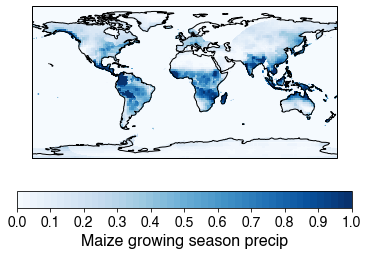

In [110]:
cRange=[0, 1]
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.add_feature(cartopy.feature.STATES, edgecolor='black')
c = plt.contourf(lon, lat, np.clip(np.nanmean(seasonalPrecip, axis=2), cRange[0], cRange[1]), cmap='Blues', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .1))
cbar.set_label('%s growing season precip'%crop)
ax.coastlines()